In [1]:
from tqdm import tqdm
import numpy as np
import os

In [2]:
LOAD_FROM_URL = False
IMAGES_PATH = GQA_IMAGES_DIR
ORIGINAL_REPO_TESTDEV_FEATURES="vg_gqa_imgfeat/gqa_testdev_obj36.tsv"

In [3]:
if LOAD_FROM_URL:
    IMG_ID = None
    IMG_PATH = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"
else:   
    IMG_ID = "n216553"
    IMG_PATH = os.path.join(IMAGES_PATH, f"{IMG_ID}.jpg")


In [4]:
# Load features from the original LXMERT repo

import sys
import csv
import base64

csv.field_size_limit(sys.maxsize)
FIELDNAMES = [
    "img_id",
    "img_h",
    "img_w",
    "objects_id",
    "objects_conf",
    "attrs_id",
    "attrs_conf",
    "num_boxes",
    "boxes",
    "features",
]
orig_item = None
if IMG_ID is not None:
    with open(ORIGINAL_REPO_TESTDEV_FEATURES) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        for item in tqdm(reader):

            for key in ["img_h", "img_w", "num_boxes"]:
                item[key] = int(item[key])

            boxes = item["num_boxes"]
            decode_config = [
                ("objects_id", (boxes,), np.int64),
                ("objects_conf", (boxes,), np.float32),
                ("attrs_id", (boxes,), np.int64),
                ("attrs_conf", (boxes,), np.float32),
                ("boxes", (boxes, 4), np.float32),
                ("features", (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                item[key] = item[key].reshape(shape)
                item[key].setflags(write=False)

            # Normalize the boxes (to 0 ~ 1)
            item["normalized_boxes"] = item["boxes"].copy()
            img_h, img_w = item["img_h"], item["img_w"]
            item["normalized_boxes"][:, (0, 2)] /= img_w
            item["normalized_boxes"][:, (1, 3)] /= img_h
            item["normalized_boxes"].setflags(write=False)

            if item["img_id"] == IMG_ID:
                orig_item = item
                break

0it [00:00, ?it/s]


In [5]:
# Prepare to generate features and visualize
from processing_image import Preprocess
from visualizing_image import SingleImageViz
import io
from IPython.display import clear_output, Image, display
import PIL.Image
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)
image_preprocess = Preprocess(frcnn_cfg)
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
gqa_answers = utils.get_data(GQA_URL)
BOXES_LIMIT=frcnn_cfg.max_detections

# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))



loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /media/disk1/eladsegal/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [6]:
import torch
def convert_orig_to_new(item):
    output_dict = {
        "obj_ids": torch.from_numpy(orig_item["objects_id"]).unsqueeze(0),
        "obj_probs": torch.from_numpy(orig_item["objects_conf"]).unsqueeze(0),
        "attr_ids": torch.from_numpy(orig_item["attrs_id"]).unsqueeze(0),
        "attr_probs": torch.from_numpy(orig_item["attrs_conf"]).unsqueeze(0),
        "sizes": torch.Tensor([orig_item["img_h"], orig_item["img_w"]]).unsqueeze(0), # Doesn't match due to resizing
        "preds_per_image": torch.IntTensor([orig_item["num_boxes"]]),
        "roi_features": torch.from_numpy(orig_item["features"]).unsqueeze(0),
        "boxes": torch.from_numpy(orig_item["boxes"]).unsqueeze(0),
        "normalized_boxes": torch.from_numpy(orig_item["normalized_boxes"]).unsqueeze(0)
    }
    return output_dict

In [7]:
images, sizes, scales_yx = image_preprocess(IMG_PATH)
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)


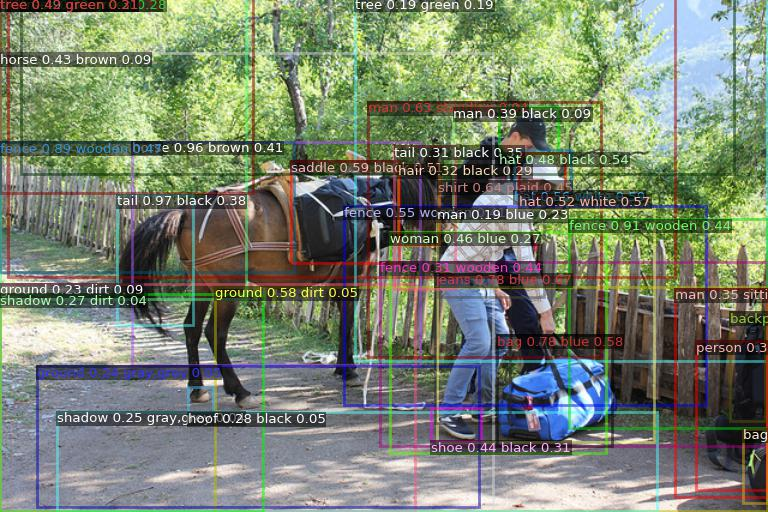

In [8]:
if orig_item is not None:
    frcnn_visualizer = SingleImageViz(IMG_PATH, id2obj=objids, id2attr=attrids)

    x = convert_orig_to_new(orig_item)
    frcnn_visualizer.draw_boxes(
        x.get("boxes")[:,:BOXES_LIMIT],
        x.get("obj_ids")[:,:BOXES_LIMIT],
        x.get("obj_probs")[:,:BOXES_LIMIT],
        x.get("attr_ids")[:,:BOXES_LIMIT],
        x.get("attr_probs")[:,:BOXES_LIMIT],
    )
    showarray(frcnn_visualizer._get_buffer())

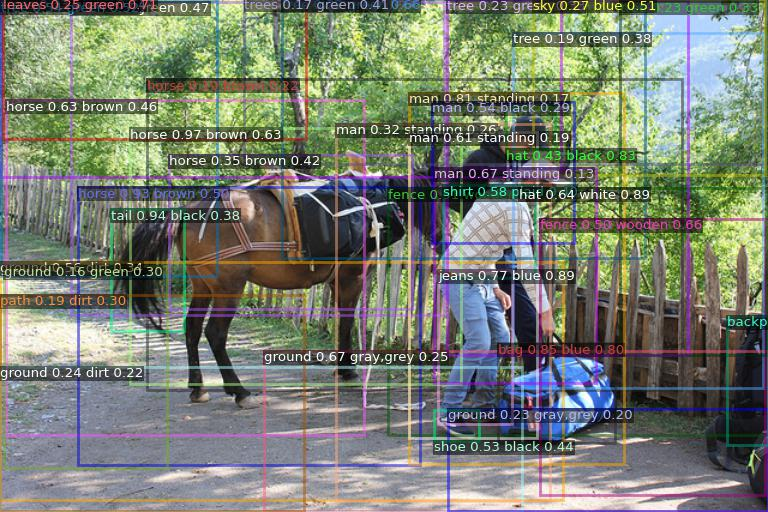

In [9]:
frcnn_visualizer = SingleImageViz(IMG_PATH, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes")[:,:BOXES_LIMIT],
    output_dict.get("obj_ids")[:,:BOXES_LIMIT],
    output_dict.get("obj_probs")[:,:BOXES_LIMIT],
    output_dict.get("attr_ids")[:,:BOXES_LIMIT],
    output_dict.get("attr_probs")[:,:BOXES_LIMIT],
)
showarray(frcnn_visualizer._get_buffer())

In [10]:
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
]

test_questions_for_n216553 = [
    "What color is the wood fence?",
    "How big is the bag?",
    "What length is the tail?",
    "What animal is standing against the fence made of wood?",
    "What is common to the bag and the sky?"
]

if LOAD_FROM_URL:
    for test_question in test_questions_for_url2:
        inputs = lxmert_tokenizer(
            test_question,
            padding="max_length",
            max_length=20,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        output_gqa = lxmert_gqa(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=output_dict.get("roi_features"),
            visual_pos=output_dict.get("normalized_boxes"),
            token_type_ids=inputs.token_type_ids,
            output_attentions=False,
        )

        pred_gqa = output_gqa["question_answering_score"].argmax(-1)
        print("Question:", test_question)
        print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])
else:
    for test_question in test_questions_for_n216553:
        inputs = lxmert_tokenizer(
            test_question,
            padding="max_length",
            max_length=20,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        output_gqa = lxmert_gqa(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=output_dict.get("roi_features"),
            visual_pos=output_dict.get("normalized_boxes"),
            token_type_ids=inputs.token_type_ids,
            output_attentions=False,
        )

        orig_output_gqa = lxmert_gqa(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=x.get("roi_features"),
            visual_pos=x.get("normalized_boxes"),
            token_type_ids=inputs.token_type_ids,
            output_attentions=False,
        )

        print(output_gqa["question_answering_score"][:10])
        print(orig_output_gqa["question_answering_score"][:10])

        pred_gqa = output_gqa["question_answering_score"].argmax(-1)
        orig_pred_gqa = orig_output_gqa["question_answering_score"].argmax(-1)
        print("Question:", test_question)
        print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])
        print("prediction from orig LXMERT GQA:", gqa_answers[orig_pred_gqa])


tensor([[ 2.6800, -1.0330,  1.6444,  ..., -1.0325,  0.4651,  1.9314]],
       grad_fn=<SliceBackward>)
tensor([[ 3.5030, -1.0977,  1.8427,  ..., -0.5371,  0.6032,  2.3763]],
       grad_fn=<SliceBackward>)
Question: What color is the wood fence?
prediction from LXMERT GQA: brown
prediction from orig LXMERT GQA: brown
tensor([[0.2999, 3.1070, 1.4956,  ..., 1.5404, 0.9053, 3.8375]],
       grad_fn=<SliceBackward>)
tensor([[0.2541, 3.1697, 0.8868,  ..., 1.1026, 0.7836, 3.1271]],
       grad_fn=<SliceBackward>)
Question: How big is the bag?
prediction from LXMERT GQA: large
prediction from orig LXMERT GQA: large
tensor([[-1.4500,  0.0068, -1.0272,  ..., -0.4465, -0.4271, -2.4956]],
       grad_fn=<SliceBackward>)
tensor([[-0.4181, -0.0263, -0.0092,  ...,  0.0449,  0.0360, -1.5288]],
       grad_fn=<SliceBackward>)
Question: What length is the tail?
prediction from LXMERT GQA: long
prediction from orig LXMERT GQA: long
tensor([[-1.8407,  4.3243, -0.9815,  ...,  3.7701, -0.3039, -0.3918]],
 